In [11]:
from IPython import display
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import torch.utils.data as data_utils
import matplotlib
import matplotlib.pyplot as plt

import time
from visdom import Visdom

In [12]:
# Visdom
vis = Visdom()

vis.line(np.zeros(2), opts=dict(
    title="LossOverEpochs",
    xlabel="epoch",
    y_label="loss"
))

Setting up a new session...


'window_3900402f0a4404'

In [13]:
file_path = "input/creditcard.csv"
df = pd.read_csv(file_path)

x = df.iloc[:, :-1].values
y = df.iloc[:,-1:].values
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 21, shuffle = True, stratify = y)

# Store Num Features
n_features = x.shape[1]

# Center Mean and Unit Variance
x_train = preprocessing.scale(x_train, axis = 0)
x_test = preprocessing.scale(x_test, axis = 0)

# Mimic Real Data
x_train = x_train[np.ravel(y_train == 0)]
y_train = y_train[y_train == 0]

# To Tensor
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).double()
y_test = torch.from_numpy(y_test).double()
# if torch.cuda.is_available():
#         x_train = x_train.cuda()
#         x_test = x_test.cuda()
#         y_train = y_train.cuda()
#         y_test = y_test.cuda()

# Creates Data Loader
ds_train = data_utils.TensorDataset(x_train, y_train)
data_loader = data_utils.DataLoader(ds_train, batch_size=100, shuffle=True)

In [14]:
# Noise Library
num_noise_features = 100

def uniform_noise(num_elements):
    noise = torch.rand(num_elements, num_noise_features)
    if torch.cuda.is_available():
        return noise.cuda()
    return noise

def gaussian_noise(num_elements, mean = 0, stddev = 1):
    noise = torch.empty(num_elements, num_noise_features).normal_(mean, stddev)
    if torch.cuda.is_available():
        return noise.cuda()
    return noise

In [15]:
# References
# https://github.com/soumith/ganhacks <-- real useful
# https://github.com/diegoalejogm/gans
# https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

# GAN NETWORKS

# Regular Descriminator Network
class DiscriminatorNetwork(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNetwork, self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden4 = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x  = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.out(x)
        return x

# Regular Generator Network    
class GeneratorNetwork(torch.nn.Module):
    def __init__(self):
        super(GeneratorNetwork, self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(num_noise_features, 128),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(32, n_features),
            nn.Tanh()
        )
    
    def forward(self, x):
        x  = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [16]:
# Data Creation Wrappers

def real_target(size):
    target = Variable(torch.ones(size, 1))
    if torch.cuda.is_available():
        return target.cuda()
    return target

def fake_target(size):
    target = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available():
        return target.cuda()
    return target

def synthesize_data(gen_nn, real_data, noise_function):
    batch_size = real_data.size()[0]
    noise = noise_function(batch_size)
    fake_data = gen_nn(noise)
#     if torch.cuda.is_available():
#         return fake_data.cuda()
    return fake_data

In [17]:
# Training Functions
def train_discriminator(discr_nn, discr_optimizer, gen_nn, real_data, noise_function):
    discr_optimizer.zero_grad()
    
    # Makes Fake Data    
    batch_size = real_data.size(0)
    fake_data = synthesize_data(gen_nn, real_data, noise_function)
    
    # Prediction On Fake Data     
    fake_discr_pred = discr_nn(fake_data)
    test = fake_target(batch_size)
    fake_loss = loss(fake_discr_pred, fake_target(batch_size))
    fake_loss.backward()
    
    # Prediction On Real Data     
    real_discr_pred = discr_nn(real_data)
    real_loss = loss(real_discr_pred, real_target(batch_size))
    real_loss.backward()
    
    discr_optimizer.step()
    
    return fake_loss + real_loss

def train_generator(gen_nn, gen_optimizer, discr_nn, real_data, noise_function):
    gen_optimizer.zero_grad()
    
    # Makes Fake Data
    batch_size = real_data.size(0)
    fake_data = synthesize_data(gen_nn, real_data, noise_function)
    
    # Prediction On Fake Data     
    fake_discr_pred = discr_nn(fake_data)
    gen_loss = loss(fake_discr_pred, real_target(batch_size)) # Maximizing as opposed to minimizeing
    gen_loss.backward()
    
    gen_optimizer.step()
    
    return gen_loss

In [18]:
# Density Estimation
def GetDensityEstimation(data):
    kde = KernelDensity(bandwidth=0.5, kernel="gaussian")
    return kde.fit(data)

In [19]:
# Evaluations
def EvaluateHellingerDistance(gen_nn, kde_function, real_data, noise_function):
    fake_data = synthesize_data(gen_nn, real_data, noise_function)
    
#     fig, axs = plt.subplots(2)
    
    real_data_numpy = real_data.detach().cpu().numpy()#[:,0].reshape(-1,1)
    real_kde = kde_function(real_data_numpy)
    real_log_dens = real_kde.score_samples(real_data_numpy)
    real_log_dens = np.exp(real_log_dens)
    
#     print(real_data_numpy.shape, real_log_dens.shape)
#     axs[0].scatter(real_data_numpy[0,real_log_dens)
    
    fake_data_numpy = fake_data.detach().cpu().numpy()#[:,0].reshape(-1,1)
    fake_kde = kde_function(fake_data_numpy)
    fake_log_dens = fake_kde.score_samples(real_data_numpy)
    fake_log_dens = np.exp(fake_log_dens)
    print(np.sum(fake_log_dens))
#     axs[1].scatter(real_data_numpy,fake_log_dens)
    
    return np.sqrt(np.sum((np.sqrt(real_log_dens) - np.sqrt(fake_log_dens)) ** 2)) / np.sqrt(2)
    

In [20]:
# Plots
def PlotLoss(loss_history):
    discr_loss_history = loss_history[0]
    gen_loss_history = loss_history[1]
    time_range = list(range(len(discr_loss_history)))
    plt.plot(time_range, discr_loss_history, label = "discr_loss")
    plt.plot(time_range, gen_loss_history, label = "gen_loss")

In [21]:
# Variables

# Models
discr_nn = DiscriminatorNetwork()
gen_nn = GeneratorNetwork()
if torch.cuda.is_available():
    discr_nn.cuda()
    gen_nn.cuda()

# Optimizers
discr_optimizer = optim.SGD(discr_nn.parameters(), lr=0.0003)
gen_optimizer = optim.Adam(gen_nn.parameters(), lr=0.0003)

# Loss
loss = nn.BCELoss()

Epoch 1, 500 / 2275
discr_loss :  tensor(1.3903, device='cuda:0', grad_fn=<AddBackward0>)
gen_loss :  tensor(0.6719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


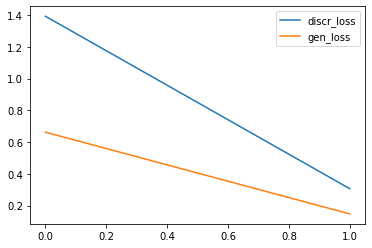

Time Elapsed :  0.118682861328125


KeyboardInterrupt: 

In [22]:
# Test
num_epochs = 100
loss_history = [[],[]]
for epoch in range(num_epochs):
    loss_history[0].append(0)
    loss_history[1].append(0)
    
    for n_batch, (batch, _) in enumerate(data_loader):
#         print(batch.shape)
        real_batch = Variable(batch)
        if torch.cuda.is_available():
            real_batch = real_batch.to("cuda")
        
        t_start = millis = time.time()
        batch_size = real_batch.size(0)
        
        discr_loss = train_discriminator(discr_nn, discr_optimizer, gen_nn, real_batch, uniform_noise)
        gen_loss = train_generator(gen_nn, gen_optimizer, discr_nn, real_batch, uniform_noise)
        
        # Loss History
        loss_history[0][epoch] += discr_loss / len(data_loader)
        loss_history[1][epoch] += gen_loss / len(data_loader)
        
        if (n_batch % 100 == 0):
            display.clear_output(True)
            
            print("Epoch {}, {} / {}".format(epoch, n_batch, len(data_loader)))
            print("discr_loss : ", discr_loss)
            print("gen_loss : ", gen_loss)            
#             hellinger_dist = EvaluateHellingerDistance(gen_nn, GetDensityEstimation, real_batch, uniform_noise)
#             print("hellinger_dist : ", (hellinger_dist))

            PlotLoss(loss_history)
            plt.legend()
            plt.show()
            
            t_end = millis = time.time()
            print("Time Elapsed : ", t_end - t_start)

#     loss_history[0][epoch] /= len(data_loader)
#     loss_history[1][epoch] /= len(data_loader)
            
            